In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.max_colwidth=500
import tensorflow as tf
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt
import re,string,unicodedata

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'marlesson/news-of-the-site-folhauol'
!unzip -qq news-of-the-site-folhauol.zip
!rm news-of-the-site-folhauol.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 96% 180M/187M [00:01<00:00, 139MB/s]
100% 187M/187M [00:01<00:00, 121MB/s]


In [67]:
# Carregando o dataset
df=pd.read_csv("articles.csv",encoding="utf8")
df.head(2)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem força como cabo eleitoral","Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está ""lascado"", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer. Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, d...",2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/1925743-lula-diz-que-esta-lascado-mas-que-ainda-tem-forca-como-cabo-eleitoral.shtml
1,"'Decidi ser escrava das mulheres que sofrem', diz cantora Oumou Sangaré","Para Oumou Sangaré, cantora e ativista malinesa, o sofrimento da mulher é universal. ""Canto com todas as minhas forças e vejo mulheres chorando ao meu redor"", disse durante um encontro na Casa da Cultura de Paraty, no Rio de Janeiro, neste domingo (8). Herdeira da tradição musical de sua família –sua avó foi uma ""grande estrela"" do país africano–, ela conta que começou a cantar na rua para ajudar nas finanças de casa após o divórcio dos pais, que deixou seis filhos dependentes de sua mãe, t...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10/1925745-decidi-ser-escrava-das-mulheres-que-sofrem-diz-cantora-oumou-sangare.shtml


In [68]:
# Ajustando o dataset
df.drop_duplicates(subset=["text"],inplace=True)
df.drop(['subcategory','link','date'],axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()
print(df.shape)

(165901, 3)


In [69]:
# Pegando as 7 categorias mais comuns no dataset
category_counts = df['category'].value_counts()
print(category_counts)
top_seven_categories = category_counts.head(7)
df = df[df['category'].isin(top_seven_categories.index)]
df.shape

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

(133842, 3)

In [70]:
# Criando um mapeamento de categoria para números
category_to_number = {category: i for i, category in enumerate(top_seven_categories.index)}
print(category_to_number)

# Substituir as categorias por números em todo o DataFrame
df['category'] = df['category'].replace(category_to_number)
df.head(3)

{'poder': 0, 'colunas': 1, 'mercado': 2, 'esporte': 3, 'mundo': 4, 'cotidiano': 5, 'ilustrada': 6}


,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem força como cabo eleitoral","Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está ""lascado"", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer. Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, d...",0
1,"'Decidi ser escrava das mulheres que sofrem', diz cantora Oumou Sangaré","Para Oumou Sangaré, cantora e ativista malinesa, o sofrimento da mulher é universal. ""Canto com todas as minhas forças e vejo mulheres chorando ao meu redor"", disse durante um encontro na Casa da Cultura de Paraty, no Rio de Janeiro, neste domingo (8). Herdeira da tradição musical de sua família –sua avó foi uma ""grande estrela"" do país africano–, ela conta que começou a cantar na rua para ajudar nas finanças de casa após o divórcio dos pais, que deixou seis filhos dependentes de sua mãe, t...",6
2,Três reportagens da Folha ganham Prêmio Petrobras de Jornalismo,"Três reportagens da Folha foram vencedoras do Prêmio Petrobras de Jornalismo, anunciado na noite desta segunda-feira (9). O jornal ganhou a premiação nas categorias Economia, com a criação do REM-F (Ranking de Eficiência dos Municípios-Folha), Regional SP-Sul, com uma série de reportagens sobre dados sigilosos do governo Geraldo Alckmin (PSDB), e Ciência e Tecnologia, com o especial ""Tudo sobre o mosquito"". A vencedora do Grande Prêmio foi a reportagem ""Terra bruta - Pistolagem, devastação...",0


In [71]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
# Limpando o texto
# Removendo
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removendo URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removendo stopwords do texto
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removendo ruído do texto
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
# Aplicando a função de limpeza ao texto
df['text']=df['text'].apply(denoise_text)

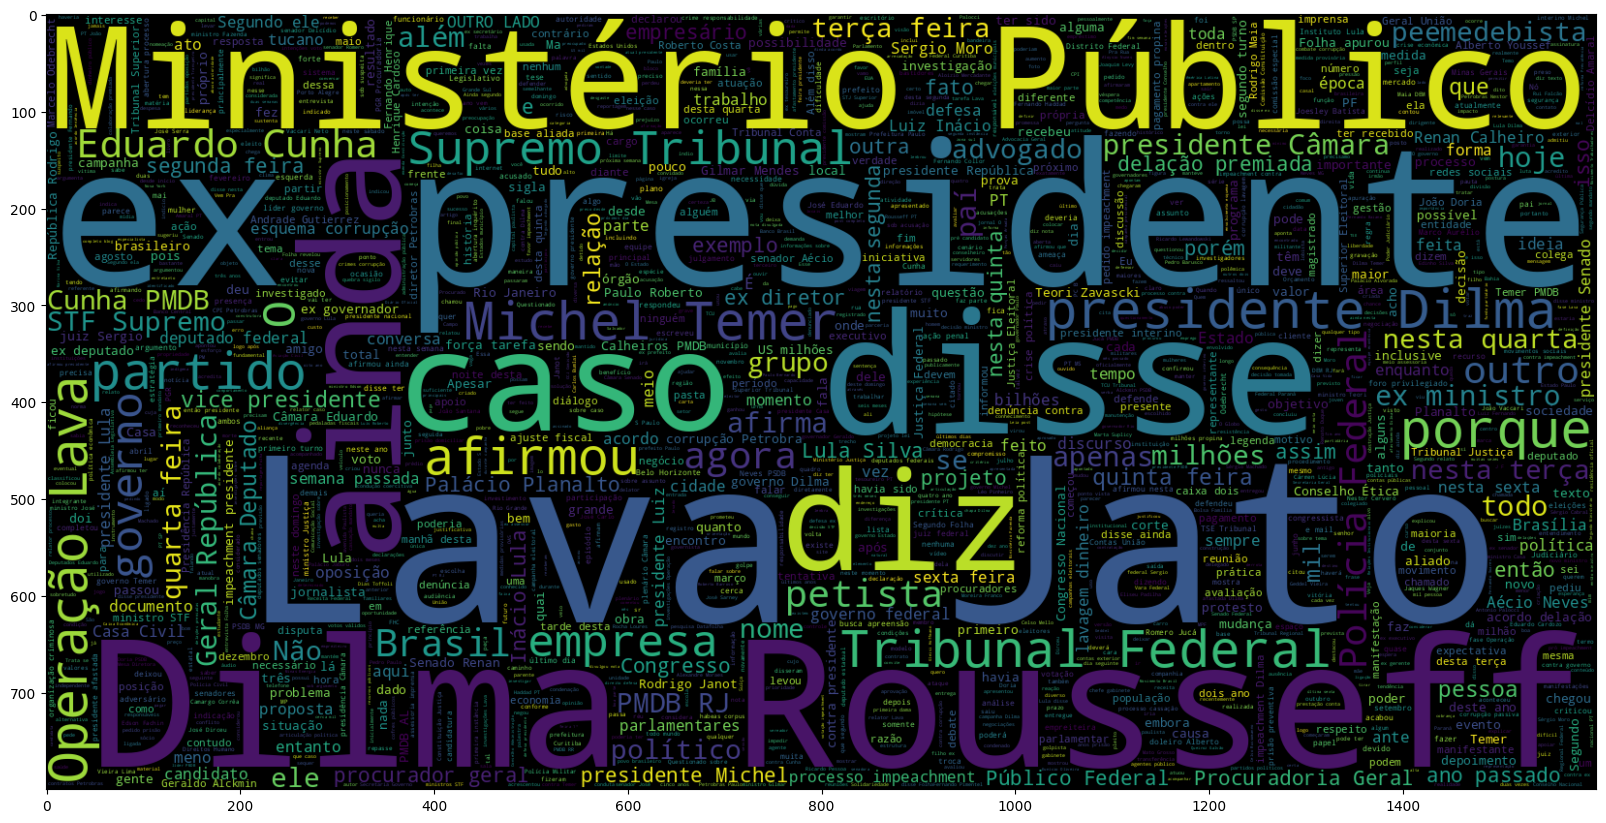

In [73]:
# Wordcloud para a categoria 0 - (Poder)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [74]:
words = []
for i in df.text.values:
    words.append(i.split())
words[:2]

[['possibilidade',
  'condenação',
  'impedir',
  'candidatura',
  '2018,',
  'ex-presidente',
  'Luiz',
  'Inácio',
  'Lula',
  'Silva',
  'fez,',
  'nesta',
  'segunda',
  '(9),',
  'discurso',
  'inflamado',
  'contra',
  'Lava',
  'Jato,',
  'disse',
  'saber',
  '"lascado",',
  'exigiu',
  'pedido',
  'desculpas',
  'juiz',
  'Sergio',
  'Moro',
  'afirmou',
  'que,',
  'disputa',
  'Planalto,',
  'cabo',
  'eleitoral',
  'expressivo',
  'sucessão',
  'Michel',
  'Temer.',
  'Segundo',
  'petista,',
  'réu',
  'sete',
  'ações',
  'penais,',
  'objetivo',
  'Moro',
  'impedir',
  'candidatura',
  'ano',
  'vem,',
  'desidratando-o,',
  'inclusive,',
  'apoio',
  'nome',
  'alternativo,',
  'ex-prefeito',
  'Paulo',
  'Fernando',
  'Haddad',
  '(PT),',
  'caso',
  'possa',
  'concorrer',
  'Presidência.',
  '"Eu',
  'sei',
  'tô',
  'lascado,',
  'todo',
  'dia',
  'processo.',
  'quero',
  'Moro',
  'absolva,',
  'quero',
  'peça',
  'desculpas",',
  'disse',
  'Lula',
  'durante'

<h1>Glove</h1>

In [75]:
from keras.utils import to_categorical
y = df['category'].values

# Converte y para one-hot encoding
y = to_categorical(y, num_classes=7)
x_train,x_test,y_train,y_test = train_test_split(df.text, y, test_size = 0.3 , random_state = 0)

In [76]:
max_features = 35000
maxlen = 100

In [77]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.preprocessing.sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [78]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = keras.preprocessing.sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [80]:
EMBEDDING_FILE = 'sample_data/glove_s100.txt'

In [91]:
batch_size = 128
epochs = 2
embed_size = 100

In [88]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Carregar os embeddings GloVe
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [102]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

TRAINING GLOVE EMBEDDINGS MODEL

In [103]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(len(word_index) + 1, output_dim=embed_size, weights=[embedding_matrix], input_length=100, trainable=True))
#LSTM
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(len(category_to_number), activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [104]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          27830300  
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 28066595 (107.07 MB)
Trainable params: 28066595 (107.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

Epoch 1/2
732/732 [==============================] - 2491s 3s/step - loss: 0.1723 - acc: 0.7635 - val_loss: 0.1240 - val_acc: 0.8362
Epoch 2/2
732/732 [==============================] - 2522s 3s/step - loss: 0.1075 - acc: 0.8599 - val_loss: 0.1010 - val_acc: 0.8670


In [95]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

1255/1255 [==============================] - 126s 100ms/step - loss: 0.1010 - acc: 0.8670
Accuracy of the model on Testing Data is -  86.69588565826416


ANALYSIS AFTER TRAINING OF GLOVE EMBEDDINGS MODEL

In [96]:
# Fazendo predições com o modelo
pred_probs = model.predict(X_test)

# Convertendo as probabilidades preditas nas classes previstas
pred = np.argmax(pred_probs, axis=1)
print(pred[:5])

1255/1255 [==============================] - 143s 113ms/step
[3 5 2 5 5]


In [97]:
print(y_test)
# Convertendo y_test de one-hot encoding para rótulos inteiros
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[3 5 2 ... 0 0 2]


In [101]:
print(classification_report(y_test_labels, pred, target_names = ['Poder','Colunas','Mercado','Esporte','Mundo','Cotidiano','Ilustrada']))

              precision    recall  f1-score   support

       Poder       0.86      0.83      0.85      6542
     Colunas       0.82      0.79      0.81      6465
     Mercado       0.86      0.84      0.85      6352
     Esporte       0.95      0.96      0.95      5973
       Mundo       0.87      0.91      0.89      5145
   Cotidiano       0.84      0.86      0.85      5046
   Ilustrada       0.84      0.92      0.88      4630

    accuracy                           0.87     40153
   macro avg       0.87      0.87      0.87     40153
weighted avg       0.87      0.87      0.87     40153



In [99]:
cm = confusion_matrix(y_test_labels,pred)
cm

array([[5413,  418,  273,   27,   74,  290,   47],
       [ 209, 5085,  232,  158,  231,  143,  407],
       [ 371,  239, 5343,   24,  121,  169,   85],
       [  31,   77,   17, 5706,   41,   72,   29],
       [  48,   97,  133,   22, 4678,   54,  113],
       [ 162,  142,  132,   39,  119, 4344,  108],
       [  32,  106,   48,    9,   87,  106, 4242]])

<Axes: >

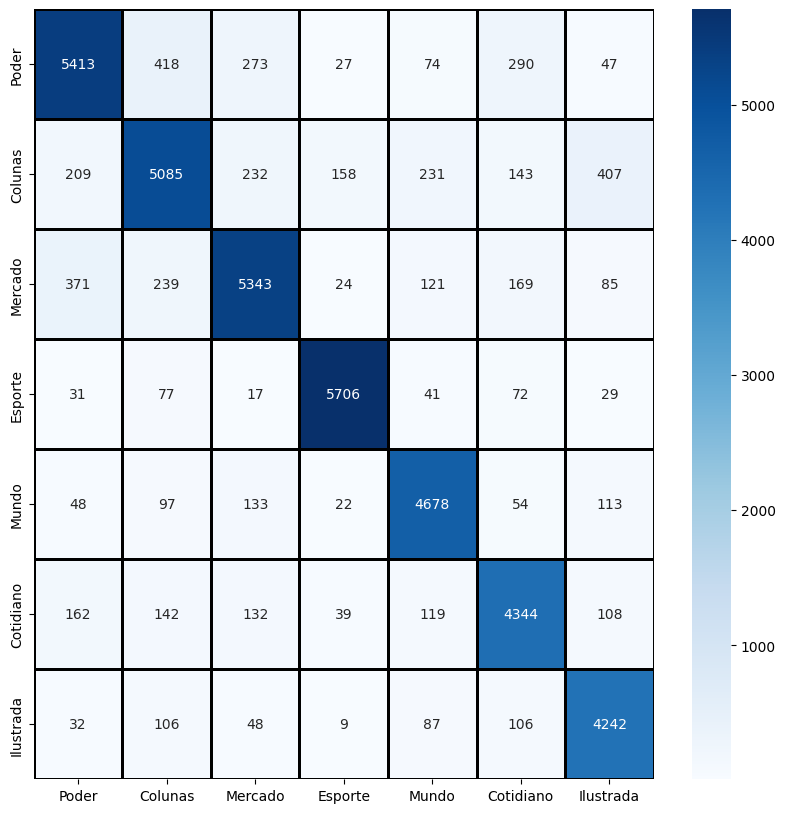

In [100]:
cm = pd.DataFrame(cm , index = ['Poder','Colunas','Mercado','Esporte','Mundo','Cotidiano','Ilustrada'] , columns = ['Poder','Colunas','Mercado','Esporte','Mundo','Cotidiano','Ilustrada'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Poder','Colunas','Mercado','Esporte','Mundo','Cotidiano','Ilustrada'] , yticklabels = ['Poder','Colunas','Mercado','Esporte','Mundo','Cotidiano','Ilustrada'])